# NYC Taxi Data, Hotel Pairing Experiment

This notebook is meant to serve as a proof-of-concept for pairing public record New York City taxi data (pick-ups, drop-offs) with a few hotels in the city.

In [1]:
# imports...
import csv, imp, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import gmplot
from IPython.display import Image, display
from IPython.core.display import HTML
import webbrowser

# importing helper methods
from util import *

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# matplotlib setup
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### Importing and Cleaning Data

We first read the .csv file into memory and store the columns of the data which we want to use (Do we need any other columns besides latitude and longitude?).

For a first pass, I use the Green taxicab data from January 2016 from the NYC Taxi & Limousine Commission website (http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml). The Yellow taxicab datasets by month are ~1.65Gb, which takes a bit to load and even longer to process (calculate distances).

In [2]:
# change this if you want to try a different dataset
taxi_file = '../data/green_tripdata_2016-01.csv'

# let's load a single .csv file of taxi cab records (say, January 2016)
taxi_data = pd.read_csv(taxi_file)

# let's take a look at the loaded .csv file (for a sanity check)
taxi_data

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type
0,2,2016-01-01 00:29:24,2016-01-01 00:39:36,N,1,-73.928642,40.680611,-73.924278,40.698044,1,...,8.0,0.5,0.5,1.86,0.00,NaN,0.3,11.16,1,1.0
1,2,2016-01-01 00:19:39,2016-01-01 00:39:18,N,1,-73.952675,40.723175,-73.923920,40.761379,1,...,15.5,0.5,0.5,0.00,0.00,NaN,0.3,16.80,2,1.0
2,2,2016-01-01 00:19:33,2016-01-01 00:39:48,N,1,-73.971611,40.676105,-74.013161,40.646072,1,...,16.5,0.5,0.5,4.45,0.00,NaN,0.3,22.25,1,1.0
3,2,2016-01-01 00:22:12,2016-01-01 00:38:32,N,1,-73.989502,40.669579,-74.000648,40.689034,1,...,13.5,0.5,0.5,0.00,0.00,NaN,0.3,14.80,2,1.0
4,2,2016-01-01 00:24:01,2016-01-01 00:39:22,N,1,-73.964729,40.682854,-73.940720,40.663013,1,...,12.0,0.5,0.5,0.00,0.00,NaN,0.3,13.30,2,1.0
5,2,2016-01-01 00:32:59,2016-01-01 00:39:35,N,1,-73.891144,40.746456,-73.867744,40.742111,1,...,7.0,0.5,0.5,0.00,0.00,NaN,0.3,8.30,2,1.0
6,2,2016-01-01 00:34:42,2016-01-01 00:39:21,N,1,-73.896675,40.746197,-73.886192,40.745689,1,...,5.0,0.5,0.5,0.00,0.00,NaN,0.3,6.30,2,1.0
7,2,2016-01-01 00:31:23,2016-01-01 00:39:36,N,1,-73.953354,40.803558,-73.949150,40.794121,1,...,7.0,0.5,0.5,0.00,0.00,NaN,0.3,8.30,2,1.0
8,2,2016-01-01 00:24:40,2016-01-01 00:39:52,N,1,-73.994064,40.702816,-73.971573,40.679726,1,...,12.0,0.5,0.5,2.00,0.00,NaN,0.3,15.30,1,1.0
9,2,2016-01-01 00:28:59,2016-01-01 00:39:23,N,1,-73.914131,40.756641,-73.917549,40.739658,1,...,9.0,0.5,0.5,1.60,0.00,NaN,0.3,11.90,1,1.0


In [3]:
# get relevant rows of the data and store them as numpy arrays
pickup_lats, pickup_longs = np.array(taxi_data['Pickup_latitude']), np.array(taxi_data['Pickup_longitude'])
dropoff_lats, dropoff_longs = np.array(taxi_data['Dropoff_latitude']), np.array(taxi_data['Dropoff_longitude']),

# for brevity, let's just experiment with the first 10^6 datapoints.
pickup_coords = zip(pickup_lats[:1000000], pickup_longs[:1000000])
dropoff_coords = zip(dropoff_lats[:1000000], dropoff_longs[:1000000])

### Geolocating Hotels

We experiment with the geopy client for popular geolocation packages. We try the OpenStreetMap Nominatim service (https://nominatim.openstreetmap.org/), since it seems fairly accurate (investigate this?) and doesn't require authentication. I might move to Google's geolocation service (https://developers.google.com/maps/documentation/geolocation/intro) after obtaining an API key.

In [4]:
# change this variable to change the address to geolocate
hotel_address = '109 E 42nd St, New York, NY 10017' # The Beekman, A Thompson Hotel ("Best stay in New York!")

# setting up geolocator object
geolocator = Nominatim()

# storing the geocode of the above address
location = geolocator.geocode(hotel_address)
hotel_coords = (location.latitude, location.longitude)

print 'address:', location.address
print 'latitude, longitude:', hotel_coords

address: Grand Hyatt New York, 109, East 42nd Street, Murray Hill, Manhattan, New York County, NYC, New York, 10017, United States of America
latitude, longitude: (40.75204035, -73.9763263)


### Finding Nearby Pickups and Corresponding Dropoff Locations

Now, we look through our pickup / dropoff dataset and find nearby points. We'll try a number of settings for "nearby", but they all rely on the "vincenty" distance (the default distance setting for this service), which calculates the distance between two points on a spheroid (https://en.wikipedia.org/wiki/Vincenty's_formulae). This can be measured in units of meters, miles, etc.

In order to do so, we've implemented the function "__get_destinations__", which can be found in the "__util.py__" script. Consult the source code and corresponding documentation if you'd like more information.

In [5]:
%%time

# let's test out our function (change value of parameters distance, unit to modify distance criterion):
destinations = get_destinations(pickup_coords, dropoff_coords, hotel_coords, distance=2000.0, unit='meters')

# how many taxicab trips satisfy the distance criterion?
print 'number of distance-criterion-satisfying pick-up locations:', destinations.shape[1]

number of distance-criterion-satisfying pick-up locations: 6343
CPU times: user 26.2 s, sys: 80 ms, total: 26.3 s
Wall time: 26.1 s


## Visualizing Destinations

This will help us get a feel for how the destinations from our selected hotel are distributed.

For this, we've defined the function "__plot_destinations__", which can be found in the "__util.py__" script.

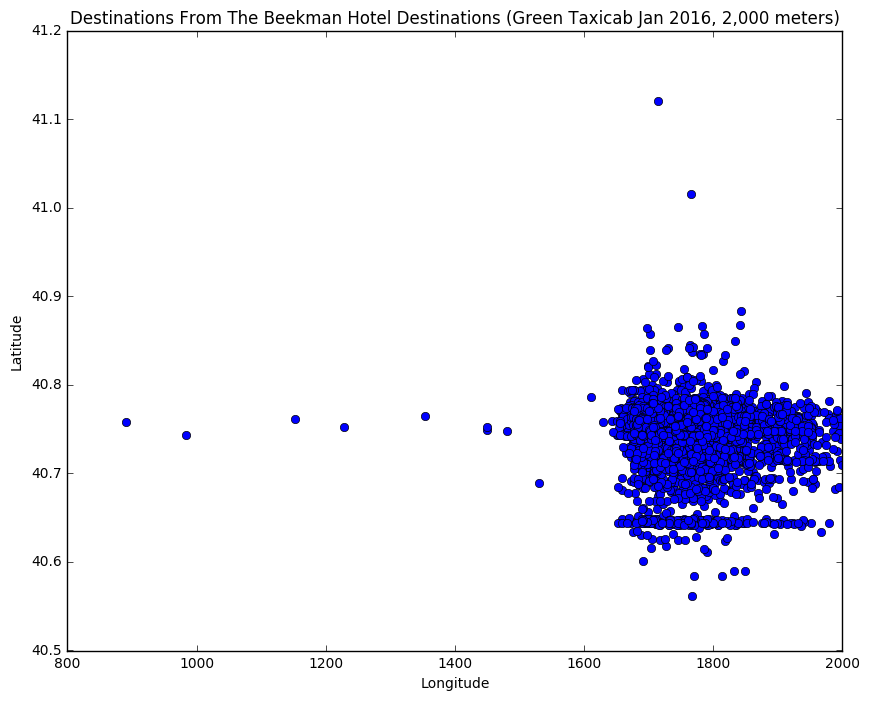

In [6]:
# try it out on the above returned destinations
plot_destinations(destinations, 'The Beekman Hotel Destinations (Green Taxicab Jan 2016, 2,000 meters)')

## Clustering Experiments

I want to try some scikit-learn (http://scikit-learn.org/stable/) clustering techniques in order to get a feel for the major destinations of the city to which these taxicab trips are traveling.

## K-Means Clustering with Cross-Validation on K

We try the K-Means clustering method (http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.fit_predict) and range over k in [2, 50], where k is the number of clusters to consider. We evaluate cluster quality using the silhouette score metric (http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score), which is an intuitive way to calculate cluster coherence using mean intra- and nearest-cluster distance.

We've defined the function "__cv_kmeans__" in "__util.py__", which performs cross-validation on the number of clusters K to use in clustering the destinations of the distance-criterion-satisfying pick-up coordinates. This function takes parameters _destinations_ and _cluster\_range_, the latter of which specifies the values of K to test in the cross-validation. Feel free to experiment with the number of clusters which variously optimize different cluster quality metrics (we cross-validate with respect to the K-means objective score, and the silhouette score metric).

In [7]:
best_score, best_score_model, best_silh_score, best_silh_model = cv_kmeans(destinations, cluster_range=[15, 20, 25, 30, 35])

print 'Best K-Means objective score:', best_score, '\n'
print 'Best K-Means objective model\'s number of clusters:', best_score_model.n_clusters, '\n'
print 'Best Silhouette score:', best_silh_score, '\n'
print 'Best Silhouette score model\'s number of clusters:', best_silh_model.n_clusters, '\n'

Best K-Means objective score: -608205.785195 

Best K-Means objective model's number of clusters: 15 

Best Silhouette score: 0.5234398375 

Best Silhouette score model's number of clusters: 30 



## Cluster Visualization

Let's try fitting clusterings and visualizing them in scatter plots.

We define the "__visualize_clustering__" function in "__util.py__", which, given parameters _destinations_, _n\_clusters_, and _title_, fits a clustering model to _destinations_ with _n\_clusters_, and shows the plot with _title_.

## Plotting...

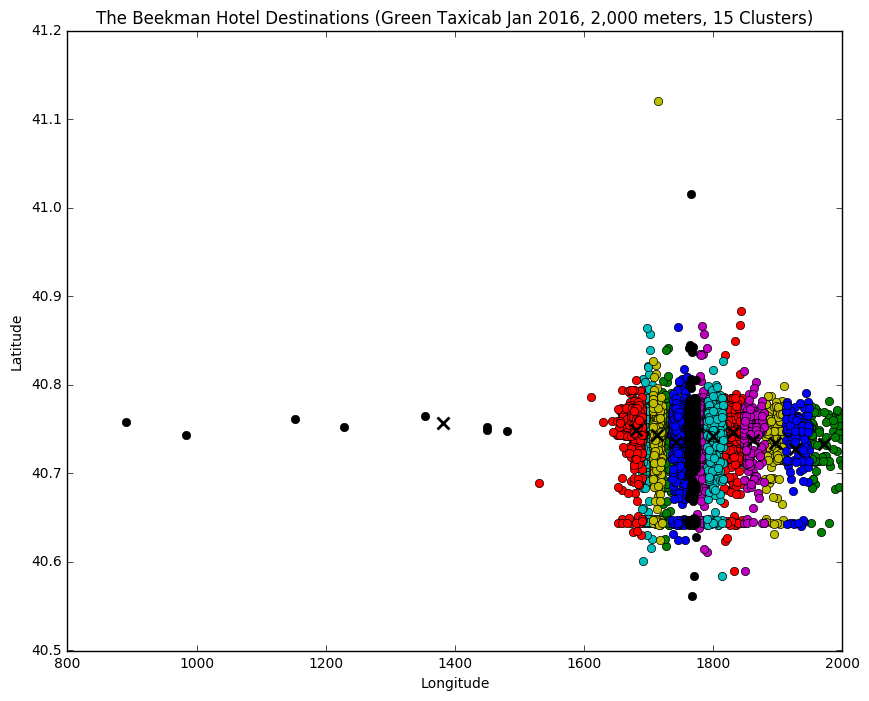

In [8]:
title = 'The Beekman Hotel Destinations (Green Taxicab Jan 2016, 2,000 meters, ' + str(best_score_model.n_clusters) + ' Clusters)'

visualize_clustering(destinations.T, best_score_model.n_clusters, title)

This looks pretty neat! Though, this technique probably won't be useful for the goals of the project.

Let's try the same experiment, but allow for points to be included at a greater distance (since this tiny dataset doesn't admit visualizations that are very interesting).

## Overlaying Destinations onto a Map of NYC

Using the Python software package gmplot, let's plot destinations onto a map of NYC. We choose to plot all destinations whose starting coordinates are within 1,750 meters of the specified hotel, because otherwise, the plot is either too sparse or too dense (at least for this hotel).

In [9]:
# getting the destinations from pick-up coordinates which are within 1,750 meters of the specified hotel
destinations = get_destinations(pickup_coords, dropoff_coords, hotel_coords, 1750.0, 'meters')

print 'Number of pickups which satisfy the distance criterion:', destinations.shape[1]

Number of pickups which satisfy the distance criterion: 2648


#### We train a clustering model as before, and get its corresponding centers and point cluster assignments.

We used 30 clusters since it produces a neat-looking visualization.

In [10]:
# getting a clustering with 30 clusters
_, model, _, _ = cv_kmeans(destinations, cluster_range=[150])

# retrieve the cluster centers and indices of destinations
cluster_centers = model.cluster_centers_
labels = model.labels_
k = model.n_clusters

#### We store the HTML codes for the available marker colors.

In [11]:
# retrieving marker .pngs
markers = os.listdir(imp.find_module('gmplot')[1] + '/markers/')

# take every third marker (don't want markers that look the same)
# markers = markers[::2]

# turn the filenames into HTML color codes
markers = [ '#' + marker[:-4] for marker in markers ]

#### We plot the clustering using the gmplot Python software package.

The plot is saved as an HTML file, which takes advantage of the Google Maps API to draw the plot.

In [15]:
# some parameters
map_name = 'green_taxicab_Jan2016_30clusters_1750meters.html'
filepath = '../img/' + map_name[:-5] + '.png'

# first, create a GoogleMapPlotter object at the center of the mean of the destinations
gmap = gmplot.GoogleMapPlotter(np.mean(destinations[0]), np.mean(destinations[1]), 13)

# now, plot clusters one at a time with varying marker colors
for clstr in range(k):    
    # plot the current cluster
    gmap.scatter(destinations[0][np.where(labels == clstr)], destinations[1][np.where(labels == clstr)], color=markers[clstr % len(markers)], edge_width=10)
    
# draw the map
gmap.draw('../img/' + map_name)

# display it in the web browser
webbrowser.open('../img/' + map_name)

[[ 1714.          1728.          1748.         ...,  1677.          1741.
   1718.        ]
 [   40.74530029    40.72485352    40.70827484 ...,    40.77054596
     40.75368881    40.76241684]
 [  -73.87316895   -73.95343781   -73.92895508 ...,   -73.92551422
    -73.94924927   -73.98973846]]


#### For fun, let's also experiment with plotting heat maps.

In [ ]:
# some parameters
map_name = 'green_taxicab_Jan2016_1750meters_heatmap.html'
filepath = '../img/' + map_name[:-5] + '.png'

gmap = gmplot.GoogleMapPlotter(np.mean(destinations[0]), np.mean(destinations[1]), 13)

# plot the heat map
gmap.heatmap(destinations[0], destinations[1], radius=50, opacity=0.8)

# draw the heat map
gmap.draw('../img/' + map_name)

# display it in the web browser
webbrowser.open('../img/' + map_name)

## Conclusions

These clustering methods and visualization probably won't be that useful in this format, but it is enlightening to play around with the data. Experimentation with other clustering techniques might prove a better approach (it will be important to use much larger datasets! Something my laptop is not equipped to handle). After finding appropriate "cluster centers", we can then use the geopy Python software package to find the address of the attraction which is located at each cluster center.

As for usefulness, even on my laptop, scraping 10^6 records, calculating distances, and storing corresponding destinations in the above fashion takes about 20 seconds per hotel. I am confident that parallelizing this code will speed this up greatly, and deploying it on a cloud computing resource (e.g., Amazon Web Services) should make this number crunching very doable (as far as memory constraints and GPU compute is concerned). 

On the other hand, performing some sort of clustering algorithm could take significantly greater resources, so careful thinking and planning will have to go into this step. Again, making use of a cloud computing resource will be crucial here.

As mentioned previously, I think that having a list of hotels and their addresses would be the next logical step. From there, it is easy to find their latitude and longitude, and then use this to calculate pick-up coordinate distances.